In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [4]:
df_credits = pd.read_csv("../data/credits.csv")

In [5]:
from ast import literal_eval

df_credits['cast'] = df_credits['cast'].apply(literal_eval)

In [6]:
def get_name_castId(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        cast_ids = [i['id'] for i in x]
        return [names, cast_ids]
    return []

In [7]:
cast = df_credits['cast']
cast = cast.apply(get_name_castId)
ids = list(df_credits['id'])
for i in range(len(cast)):
    cast[i].append(ids[i])
cast[0]

[['Tom Hanks',
  'Tim Allen',
  'Don Rickles',
  'Jim Varney',
  'Wallace Shawn',
  'John Ratzenberger',
  'Annie Potts',
  'John Morris',
  'Erik von Detten',
  'Laurie Metcalf',
  'R. Lee Ermey',
  'Sarah Freeman',
  'Penn Jillette'],
 [31,
  12898,
  7167,
  12899,
  12900,
  7907,
  8873,
  1116442,
  12901,
  12133,
  8655,
  12903,
  37221],
 862]

In [8]:
df = pd.DataFrame()
for x in cast:
    diction = {'cast_name': x[0], 'cast_id': x[1],'movie_id': x[2]}
    df = df.append(diction, ignore_index=True)
df.head()

,cast_name,cast_id,movie_id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...",8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[6837, 3151, 13567, 16757, 589, 16523, 7166]",15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ...",31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[67773, 3092, 519, 70696, 59222, 18793, 14592,...",11862


In [9]:
df_movie = pd.read_csv("../data/movies_metadata.csv")

In [10]:
df_movie = df_movie[["budget","genres","title","revenue","id"]]
df_movie.head()

,budget,genres,title,revenue,id
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,373554033.0,862
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,262797249.0,8844
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,0.0,15602
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,81452156.0,31357
4,0,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,76578911.0,11862


In [11]:
literal_eval(df_movie.genres.values[0])

[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [12]:
uniqueGenres = set([])
for i in df_movie.genres.values: # I am looping through all the rows
    genList = literal_eval(i) # convert from string to list of dict
    for j in genList: # loop through the list of dict
        uniqueGenres.add(j["name"]) # add the name of the genre to my uniqueGenres variabe
uniqueGenres

{'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}

In [13]:
rows = [] # for all the movies
genres = list(uniqueGenres) # all unique Genres

for i in df_movie.genres: #looping through all the rows/movies
  genList = literal_eval(i) #converting from string to list of dict for a particular movie
  movieGenres = [x['name'] for x in genList] # list of all the genres of the movie
  row = [] # store a list of 1s and 0s for one movie
  for j in genres: #loop through all unique genres
    row.append(int(j in movieGenres)) #checking if the genre is present in that movie - if the genre is present 1 else 0
  rows.append(row)

In [14]:
genre = pd.DataFrame(rows,columns = genres)
genre

,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,Family,History,Music,Action,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45463,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
45464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_movie = pd.concat([df_movie,genre], axis = 1) # joing the two dataframes
df_movie.shape, genre.shape

((45466, 37), (45466, 32))

In [16]:
df_movie = df_movie.drop(columns = ['genres'])

In [17]:
df_movie.head()

,budget,title,revenue,id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,30000000,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0,Grumpier Old Men,0.0,15602,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16000000,Waiting to Exhale,81452156.0,31357,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Father of the Bride Part II,76578911.0,11862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_movie["revenue"].isnull().sum()

6

In [19]:
df_movie = df_movie[df_movie['revenue'].notna()]

In [20]:
df_movie["revenue"].isnull().sum()

0

In [21]:
df_movie["revenue"][0]

373554033.0

In [22]:
sum(df_movie["revenue"] == 0)

38052

In [23]:
(sum(df_movie["revenue"] == 0)/df_movie.shape[0])*100

83.70435547734272

In [24]:
df_movie_revenue = df_movie
df_movie_revenue["revenue"] = df_movie_revenue["revenue"].replace(0, pd.np.nan)

In [25]:
df_movie_revenue["revenue"].isnull().sum()

38052

In [26]:
df_movie_revenue = df_movie_revenue[df_movie_revenue['revenue'].notna()]
df_movie_revenue["revenue"].isnull().sum()
df_movie_revenue["revenue"].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

In [27]:
df_movie_revenue["budget"] = df_movie_revenue["budget"].astype(int)
df_movie_revenue["budget"][0]

30000000

In [28]:
sum(df_movie_revenue["budget"] == 0)

2027

In [29]:
(sum(df_movie_revenue["budget"] == 0)/df_movie_revenue.shape[0])*100

27.36231101511879

In [30]:
df_movie_revenue_budget = df_movie_revenue
df_movie_revenue_budget["budget"] = df_movie_revenue_budget["budget"].replace(0, pd.np.nan)
df_movie_revenue_budget = df_movie_revenue_budget[df_movie_revenue_budget['budget'].notna()]
df_movie_revenue_budget["budget"].isnull().sum()
df_movie_revenue_budget["budget"].describe()

count    5.381000e+03
mean     3.109480e+07
std      4.016263e+07
min      1.000000e+00
25%      5.037000e+06
50%      1.700000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [31]:
df_movie_revenue_budget.head()

,budget,title,revenue,id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [32]:
df_movie_revenue_budget.shape

(5381, 36)

In [33]:
df_movie_revenue_budget.rename(columns = {'id':'movie_id'}, inplace = True)
df_movie_revenue_budget["movie_id"].astype(str).astype(int).dtypes

dtype('int64')

In [34]:
df_movie_revenue_budget["movie_id"] = df_movie_revenue_budget["movie_id"].astype(str).astype(int)
df_movie_revenue_budget.dtypes

budget                                   float64
title                                     object
revenue                                  float64
movie_id                                   int64
Vision View Entertainment                  int64
The Cartel                                 int64
TV Movie                                   int64
Romance                                    int64
Pulser Productions                         int64
Mardock Scramble Production Committee      int64
Family                                     int64
History                                    int64
Music                                      int64
Action                                     int64
Crime                                      int64
Documentary                                int64
War                                        int64
Mystery                                    int64
Animation                                  int64
GoHands                                    int64
Horror              

In [35]:
df_movie_revenue_budget_cast = df_movie_revenue_budget.merge(df, on = "movie_id", how = 'left')

In [36]:
df_movie_revenue_budget_cast.shape

(5393, 38)

In [37]:
df_movie_revenue_budget_cast.head()

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11..."
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ..."
2,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ..."
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15..."
4,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[15111, 6280, 8656, 10361, 12928, 79088]"


In [38]:
all_actors = []
for name in df_movie_revenue_budget_cast.cast_name:
    all_actors.extend(name)

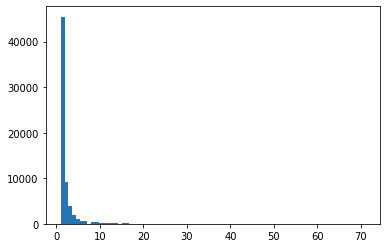

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
actors_fre = Counter(all_actors)
all_fre = list(actors_fre.values())
plt.hist(all_fre, bins = 80)
plt.show()

In [40]:
all_fre.sort()
greater5 = 0
for i in range(len(all_fre)):
    if all_fre[i] > 20:
        greater5 = i
        break
all_fre = all_fre[greater5:]
len(all_fre)

333

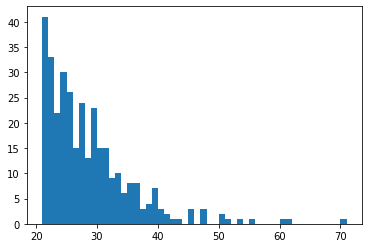

In [41]:
plt.hist(all_fre, bins = 50)
plt.show()

In [180]:
print('From this, we can assume that the top five percent of actors in the number of movies are famous actors')
all_fre = list(actors_fre.values())
all_fre.sort()
all_fre = all_fre[-100:]
print('The number of top five percent actors is', len(all_fre))
print('The top ten percent of actors have acted in at least {} films'.format(all_fre[0]))

From this, we can assume that the top five percent of actors in the number of movies are famous actors
The number of top five percent actors is 100
The top ten percent of actors have acted in at least 30 films


From this, we can assume that the top five percent of actors in the number of movies are famous actors
The number of top five percent actors is 3251
The top ten percent of actors have acted in at least 6 films

In [181]:
famous_actors = set()
for actor in actors_fre:
    if actors_fre[actor] >= 30:
        famous_actors.add(actor)

In [182]:
famous_actors_df = []
famous_actors_num_df = []
for names in df_movie_revenue_budget_cast.cast_name:
    temp = []
    n = 0
    for name in names:
        if name in famous_actors:
            temp.append(name)
            n += 1
    famous_actors_df.append(temp)
    famous_actors_num_df.append(n)

In [183]:
df_movie_revenue_budget_cast['famous_actors']= famous_actors_df
df_movie_revenue_budget_cast['num_famous_actors']= famous_actors_num_df

In [184]:
df_movie_revenue_budget_cast.head(5)

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors,profit
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[Tom Hanks],1,343554033.0
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,1,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...","[Robin Williams, Kirsten Dunst]",2,197797249.0
2,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,1,0,0,...,0,0,0,0,0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ...",[],0,65452156.0
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15...","[Robert De Niro, Danny Trejo, Philip Ettington]",3,127436818.0
4,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,1,0,0,0,0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[15111, 6280, 8656, 10361, 12928, 79088]",[],0,29350171.0


In [185]:
cond = df_movie_revenue_budget_cast.num_famous_actors > 0
df_movie_revenue_budget_cast = df_movie_revenue_budget_cast[cond]

In [186]:
df_movie_revenue_budget_cast.shape

(2375, 41)

In [187]:
df_movie_revenue_budget_cast['profit'] = df_movie_revenue_budget_cast.revenue - df_movie_revenue_budget_cast.budget

In [188]:
df_movie_revenue_budget_cast.head(5)

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors,profit
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[Tom Hanks],1,343554033.0
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,1,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...","[Robin Williams, Kirsten Dunst]",2,197797249.0
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15...","[Robert De Niro, Danny Trejo, Philip Ettington]",3,127436818.0
7,44000000.0,Nixon,13681765.0,10858,0,0,0,0,0,0,...,0,0,0,0,0,"[Anthony Hopkins, Joan Allen, Powers Boothe, E...","[4173, 11148, 6280, 228, 382, 5249, 19839, 110...",[Ed Harris],1,-30318235.0
9,52000000.0,Casino,116112375.0,524,0,0,0,0,0,0,...,0,0,0,0,0,"[Robert De Niro, Sharon Stone, Joe Pesci, Jame...","[380, 4430, 4517, 4512, 7167, 7169, 7166, 7165...",[Robert De Niro],1,64112375.0


In [189]:
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Mimic ggplot in R
matplotlib.style.use('ggplot')

<AxesSubplot:xlabel='num_famous_actors', ylabel='profit'>

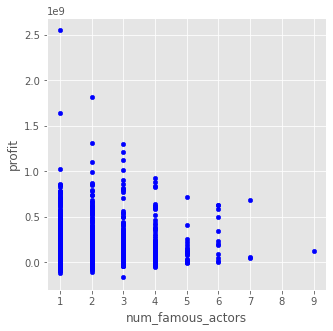

In [190]:
df_movie_revenue_budget_cast.plot(kind="scatter",  # Scatter Plot
          x="num_famous_actors",           # 'x' for x-axis
          y="profit",           # 'y' for y-axis
          figsize=(5,5),   # 5 x 5 size
          color="blue")    # blue dot

In [191]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Action"] == 1].count()[0]

705

In [192]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Adventure"] == 1].count()[0]

485

In [193]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Romance"] == 1].count()[0]

391

In [194]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Comedy"] == 1].count()[0]

874

In [195]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Crime"] == 1].count()[0]

495

In [196]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Horror"] == 1].count()[0]

138

In [197]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Drama"] == 1].count()[0]

1132

In [198]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Family"] == 1].count()[0]

259

In [199]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Fantasy"] == 1].count()[0]

262

In [200]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Mystery"] == 1].count()[0]

194

In [201]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Science Fiction"] == 1].count()[0]

297

In [202]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Thriller"] == 1].count()[0]

726

In [203]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Western"] == 1].count()[0]

46

In [204]:
df_movie_revenue_budget_cast_Drama = df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Drama"] == 1]
df_movie_revenue_budget_cast_Drama

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors,profit
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15...","[Robert De Niro, Danny Trejo, Philip Ettington]",3,127436818.0
7,44000000.0,Nixon,13681765.0,10858,0,0,0,0,0,0,...,0,0,0,0,0,"[Anthony Hopkins, Joan Allen, Powers Boothe, E...","[4173, 11148, 6280, 228, 382, 5249, 19839, 110...",[Ed Harris],1,-30318235.0
9,52000000.0,Casino,116112375.0,524,0,0,0,0,0,0,...,0,0,0,0,0,"[Robert De Niro, Sharon Stone, Joe Pesci, Jame...","[380, 4430, 4517, 4512, 7167, 7169, 7166, 7165...",[Robert De Niro],1,64112375.0
10,16500000.0,Sense and Sensibility,135000000.0,4584,0,0,0,1,0,0,...,0,0,0,0,0,"[Kate Winslet, Emma Thompson, Hugh Grant, Tom ...","[204, 7056, 3291, 207, 4566, 20769, 16700, 414...",[Tom Wilkinson],1,118500000.0
16,3600000.0,Leaving Las Vegas,49800000.0,451,0,0,0,1,0,0,...,0,0,0,0,0,"[Nicolas Cage, Elisabeth Shue, Julian Sands, R...","[2963, 1951, 6104, 6105, 6106, 6107, 6108, 610...",[Nicolas Cage],1,46200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313,10500000.0,Aftermath,3451.0,390051,0,0,0,0,0,0,...,0,0,0,0,0,"[Arnold Schwarzenegger, Scoot McNairy, Maggie ...","[1100, 59233, 11825, 1753210, 117087, 1023800,...",[Arnold Schwarzenegger],1,-10496549.0
5340,10500000.0,The Beguiled,25442939.0,399019,0,0,0,0,0,0,...,0,1,0,0,0,"[Colin Farrell, Nicole Kidman, Kirsten Dunst, ...","[72466, 2227, 205, 18050, 1423519, 1265629, 16...","[Colin Farrell, Nicole Kidman, Kirsten Dunst]",3,14942939.0
5361,5000000.0,Paris Can Wait,6700000.0,375867,0,0,0,1,0,0,...,0,0,0,0,0,"[Diane Lane, Arnaud Viard, Alec Baldwin, Cédri...","[2882, 232764, 7447, 1164462, 1427230]",[Alec Baldwin],1,1700000.0
5366,152000000.0,War for the Planet of the Apes,369907963.0,281338,0,0,0,0,0,0,...,0,0,1,0,0,"[Andy Serkis, Woody Harrelson, Steve Zahn, Kar...","[1333, 57755, 18324, 58395, 236696, 42711, 635...",[Woody Harrelson],1,217907963.0


<AxesSubplot:xlabel='num_famous_actors', ylabel='profit'>

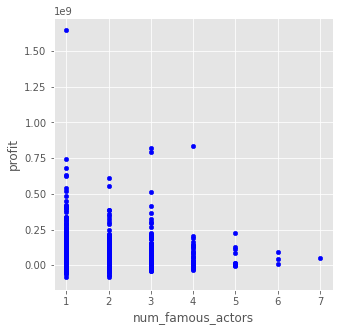

In [205]:
df_movie_revenue_budget_cast_Drama.plot(kind="scatter",  # Scatter Plot
          x="num_famous_actors",           # 'x' for x-axis
          y="profit",           # 'y' for y-axis
          figsize=(5,5),   # 5 x 5 size
          color="blue")    # blue dot

In [206]:
number_factors_total_profit = {}
number_factors_total_number = {}
for row in df_movie_revenue_budget_cast.iterrows():
    if row[1]['num_famous_actors'] in number_factors_total_profit:
        number_factors_total_profit[row[1]['num_famous_actors']] += row[1]['profit']
        number_factors_total_number[row[1]['num_famous_actors']] += 1
    else:
        number_factors_total_profit[row[1]['num_famous_actors']] = row[1]['profit']
        number_factors_total_number[row[1]['num_famous_actors']] = 1

In [207]:
number_factors_mean_profit = []
number_factors = []
for key in number_factors_total_profit:
    number_factors.append(key)
    number_factors_mean_profit.append(number_factors_total_profit[key]/number_factors_total_number[key])

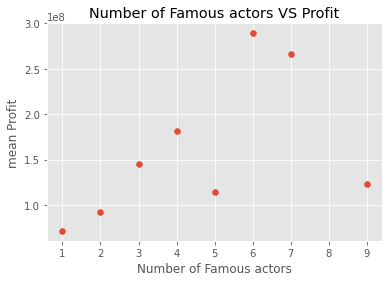

In [251]:
plt.scatter(number_factors, number_factors_mean_profit)
plt.title('Number of Famous actors VS Profit')
plt.xlabel('Number of Famous actors')
plt.ylabel('mean Profit')
plt.show()

In [229]:
X = list(df_movie_revenue_budget_cast['num_famous_actors'])
y = list(df_movie_revenue_budget_cast['profit'])
d = {y[i]:X[i] for i in range(len(X))}
sorted_d = sorted(d.items(), key = lambda x: x[1])
X = []
y = []
for p in sorted_d:
    X.append(p[1])
    y.append(p[0])
X = np.array(X).reshape(-1,1)

In [235]:
#fitting the polynomial regression model to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=10)
X_poly=poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y)

LinearRegression()

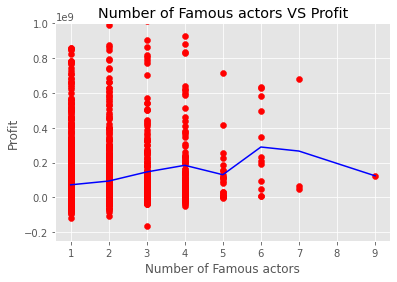

In [250]:
#Visualising the pollynomial regression model results
X_grid=np.arange(min(X),max(X),0.1)
X_grid=X_grid.reshape((len(X_grid),1))
plt.scatter(X,y,color='red')
plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Number of Famous actors VS Profit')
plt.xlabel('Number of Famous actors')
plt.ylabel('Profit')
plt.ylim([-0.25*10**9, 10**9])
plt.show()